## CMSC 35300 Final Project: Lasso Models
Shweta Kamath <br>
Nivedita Vatsa <br>
Carolyn Vilter

#### Setup

Source: https://gist.github.com/agramfort/ac52a57dc6551138e89b

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pltb
import seaborn as sns

In [20]:
import time
from math import sqrt
from scipy import linalg

In [21]:
import scipy.io as sio

In [22]:
# Import data
df = pd.read_csv("data/all_data_standardized.csv")

In [23]:
# Separate out Xs
X = df.loc[:, ~df.columns.isin(["child_id", "mother_id", "treat_alike_scale", "treat_alike_binary"])]
X = X.to_numpy()

# add columns of 1s
A = np.hstack((np.ones((len(X), 1)), X))

# Separate out two prospective ys
y_scale = df.loc[:, df.columns == "treat_alike_scale"]
y_scale = y_scale.to_numpy()

y_binary = df.loc[:, df.columns == "treat_alike_binary"]
y_binary = y_binary.to_numpy()

In [24]:
# matlab_data_file = sio.loadmat('face_emotion_data.mat')
# X = matlab_data_file['X']
# y_scale = matlab_data_file['y']

In [25]:
# # load data, make sure ‘fisheriris.mat‘ is in your working directory
# data = sio.loadmat("fisheriris.mat")

# # training data
# X = data['meas']
# y_scale = data['species']

In [38]:
df

,child_id,mother_id,treat_alike_scale,treat_alike_binary,year_at_y,gap_at_y,self_worth,yob_child,father_present,religion_freq,...,highest_expected_grade_GET MORE THAN 4 YEARS OF COLLEGE,highest_expected_grade_SOMETHING ELSE,mother_race_BLACK,"mother_race_NON-BLACK, NON-HISPANIC",mother_relig_raised_protestant,mother_relig_raised_catholic,mother_relig_raised_other,mother_relig_current_protestant,mother_relig_current_catholic,mother_relig_current_other
0,301,3,2,1,1994,13,160,1981,1.000000,2.0,...,0,0,0,1,0,1,0,0,1,0
1,302,3,1,1,1996,13,240,1983,1.000000,3.5,...,0,0,0,1,0,1,0,0,1,0
2,303,3,1,1,2000,14,220,1986,1.000000,5.0,...,0,0,0,1,0,1,0,0,0,1
3,803,8,1,1,1996,14,170,1982,0.363636,2.0,...,0,0,0,1,0,0,1,1,0,0
4,1601,16,1,1,2004,14,180,1990,1.000000,4.0,...,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5156,1255801,12558,2,1,2002,13,240,1989,0.000000,6.0,...,0,0,1,0,0,0,1,0,0,1
5157,1256602,12566,2,1,1998,13,220,1985,1.000000,6.0,...,0,0,1,0,1,0,0,1,0,0
5158,1256603,12566,1,1,2002,14,220,1988,0.888889,6.0,...,1,0,1,0,1,0,0,1,0,0
5159,1256604,12566,1,1,2004,12,230,1992,0.714286,6.0,...,1,0,1,0,1,0,0,1,0,0


### Lasso Regression
Predict repeatedly using cross validation; plot test error.

In [26]:
def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0.)


def ista(A, b, l, maxit):
    x = np.zeros(A.shape[1])
    pobj = []
    L = linalg.norm(A) ** 2  # Lipschitz constant
    time0 = time.time()
    for _ in range(maxit):
        x = soft_thresh(x + np.dot(A.T, b - A.dot(x)) / L, l / L)
        this_pobj = 0.5 * linalg.norm(A.dot(x) - b) ** 2 + l * linalg.norm(x, 1)
        pobj.append((time.time() - time0, this_pobj))

    times, pobj = map(np.array, zip(*pobj))
    return x, pobj, times


def fista(A, b, l, maxit):
    x = np.zeros(A.shape[1])
    pobj = []
    t = 1
    z = x.copy()
    L = linalg.norm(A) ** 2
    time0 = time.time()
    for _ in range(maxit):
        xold = x.copy()
        z = z + A.T.dot(b - A.dot(z)) / L
        x = soft_thresh(z, l / L)
        t0 = t
        t = (1. + sqrt(1. + 4. * t ** 2)) / 2.
        z = x + ((t0 - 1.) / t) * (x - xold)
        this_pobj = 0.5 * linalg.norm(A.dot(x) - b) ** 2 + l * linalg.norm(x, 1)
        pobj.append((time.time() - time0, this_pobj))

    times, pobj = map(np.array, zip(*pobj))
    return x, pobj, times




In [27]:
rng = np.random.RandomState(42)
m, n = A.shape

x0 = rng.rand(n)
x0[x0 < 0.9] = 0
b = np.dot(A, x0)
l = 0.5  # regularization parameter

maxit = 1000

In [28]:
x_ista, pobj_ista, times_ista = ista(A, b, l, maxit)

In [31]:
np.round(x_ista,3)

array([0.   , 0.255, 0.002, 0.026, 0.253, 0.   , 0.   , 0.002, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.155, 0.001, 0.   ,
       0.006, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [32]:
x_fista, pobj_fista, times_fista = fista(A, b, l, maxit)

In [34]:
np.round(x_fista, 3)

array([ 0.   ,  0.479,  0.003,  0.047,  0.476,  0.   ,  0.001,  0.003,
        0.   ,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
       -0.011,  0.002,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ])

In [37]:
A

array([[1.000e+00, 1.994e+03, 1.300e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.000e+00, 1.996e+03, 1.300e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.000e+00, 2.000e+03, 1.400e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [1.000e+00, 2.002e+03, 1.400e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 2.004e+03, 1.200e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 2.000e+03, 1.300e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

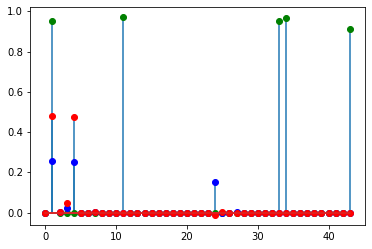

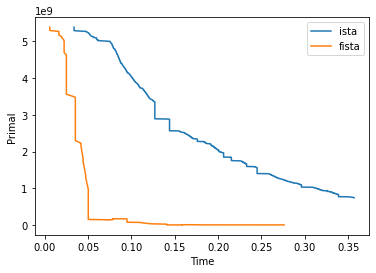

In [39]:
import matplotlib.pyplot as plt
plt.close('all')

plt.figure()
plt.stem(x0, markerfmt='go')
plt.stem(x_ista, markerfmt='bo')
plt.stem(x_fista, markerfmt='ro')

plt.figure()
plt.plot(times_ista, pobj_ista, label='ista')
plt.plot(times_fista, pobj_fista, label='fista')
plt.xlabel('Time')
plt.ylabel('Primal')
plt.legend()
plt.show()